In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from SceneR2.core import *
from SceneR2.learners import ModelLearner, ParallelLearner
from SceneR2.dataset import CANData, MovingObjectData, SingleCAN, MovingObjectData2
from SceneR2.dataset import *
from SceneR2.loss import weightedMSE
import pickle

In [4]:
! which python

/home/sufiyan/anaconda3/envs/fastai/bin/python


As loading and cleaning the dataset takes some time, we load the dataset and save it in a pickle file to be loaded below. This makes the process of loading the dataset quicker the next time we run the model.

In [ ]:
data=MovingObjectData2.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovObj2_cleaned_157_26Feb", 'wb') as f:
    pickle.dump(data, f)

Loading the dataset. To see how the dataset works, see [SceneR2/dataset.py](https://github.com/dumbPy/MTP/blob/master/SceneR2/dataset.py)

In [5]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovObj2_cleaned_157_26Feb", 'rb') as f:
    dataset=pickle.load(f)

AttributeError: Can't get attribute 'StandardSequenceScaler' on <module 'SceneR2.utils' from '/home/sufiyan/Dropbox/MTP/Code_and_Notebook/SceneR2/utils/__init__.py'>

[]
ABAReactionIndex:  353
ABAReactionStopIndex: 425
Edge_0:  []
Edge_1:  []
Reason for Braking:  Pedestrian A
Label:  2
edgePostABA:  425


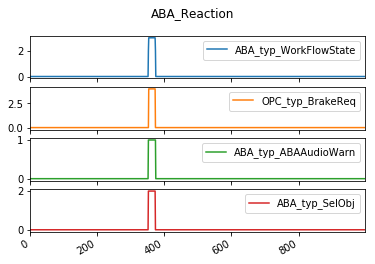

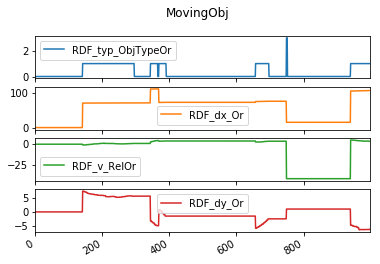

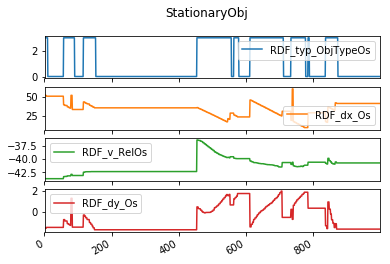

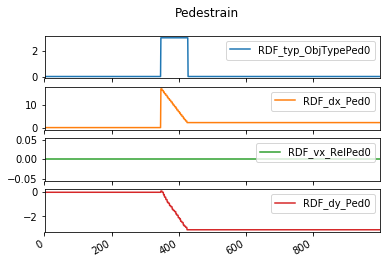

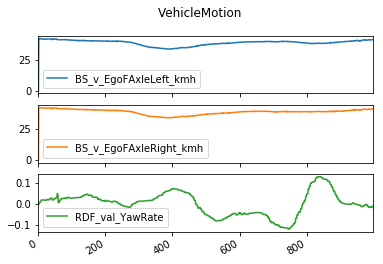

In [14]:
dataset.plot(1, supressPostABA=False, all_columns=True, verbose=True)

Total number of files in the dataset

In [6]:
len(dataset)

161

Number of files for **Left**, **Right** and **Other** classes respectively. These include flipped files for Left and Right

In [7]:
print(len([1 for x,y in dataset if y==0]))
print(len([1 for x,y in dataset if y==1]))
print(len([1 for x,y in dataset if y==2]))

61
62
38


Seperating train and test files.

In [8]:
np.random.seed(10) #seting seed for always selecting same train and test set
totalFiles=len(dataset)
testFiles=np.random.choice(totalFiles, int(0.2*totalFiles)) #20% files as test files

Defining the Dataloaders for training and validation data

In [9]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if not i in testFiles])
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if i in testFiles])

A simple model defined below is trained. It consists of a 2 Layer LSTM followed by a fully connected Layer

In [10]:
class CSVmodel(nn.Module):
    def __init__(self,categories=3, input_size=4, hidden_size=20, dropout=0.1):
        super().__init__()
        self.l1=nn.LSTM(input_size=input_size,hidden_size=hidden_size, dropout=dropout, num_layers=2)
        self.l2=nn.Linear(in_features=hidden_size,out_features=categories)
        self.softmax=nn.Softmax()
    def forward(self,x):
        x,_=self.l1(x)
        x=x[:,-1,:]
        x= self.l2(x)
        return x

ParallelLearner class takes ModelLearners that take models and other parameters like learning rate, optimization function and loss function.

In [11]:
learner=ParallelLearner(
                [ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,0.1]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [0.5,0.5,0.1]), 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.MSELoss, optim=torch.optim.SGD, 
                             modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.CrossEntropyLoss, 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' )],
        epochs=10, trainLoader=trainLoader, validLoader=testLoader)

The ParallelLearner trains all the models parallelly by using the same data

In [12]:
learner.train(300)

Plotting the loss for all the 4 models above. 

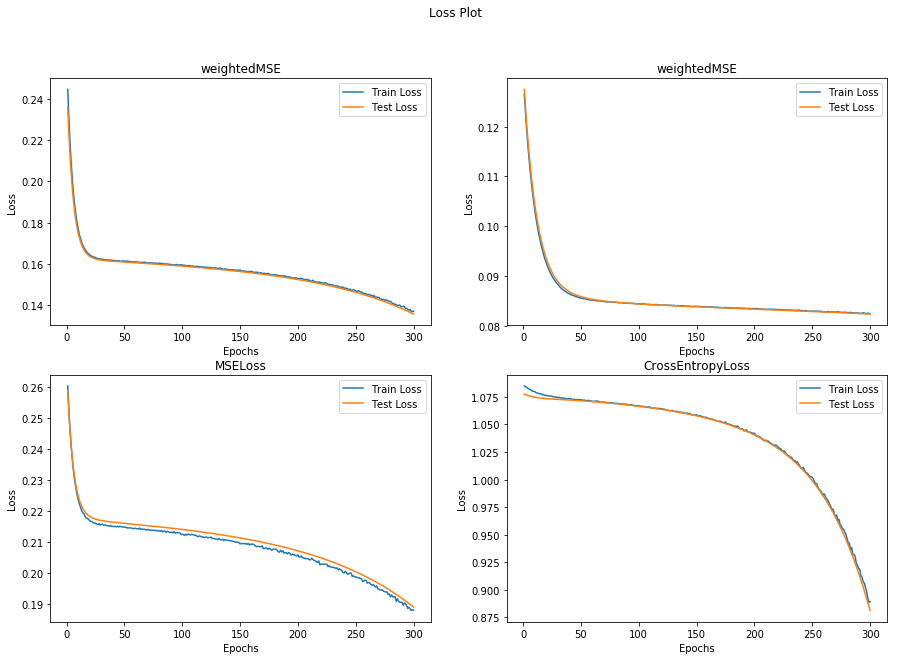

In [13]:
learner.plotLoss(figsize=(15,10))

Plotting confusion matrix for training dataset for all the four loss functions namely weighted_MSE (1,1,0.1), weighted_MSE(0.5, 0.5, 0.1), MSE and CrossEntropyLoss.

In [14]:
print("wMSE1"); print(learner.learners[0].train_confusion_matrix_list[-1])
print("wMSE2"); print(learner.learners[1].train_confusion_matrix_list[-1])
print("MSE"); print(learner.learners[2].train_confusion_matrix_list[-1])
print("CE"); print(learner.learners[3].train_confusion_matrix_list[-1])

wMSE1
[[51  0  0]
 [ 1 49  0]
 [21 10  0]]
wMSE2
[[51  0  0]
 [ 4 46  0]
 [23  8  0]]
MSE
[[50  1  0]
 [ 0 50  0]
 [23  8  0]]
CE
[[50  1  0]
 [ 0 50  0]
 [23  8  0]]


Confision Matrix for all the loss functions for test data

In [15]:
print("wMSE1"); print(learner.learners[0].valid_confusion_matrix_list[-1])
print("wMSE2"); print(learner.learners[1].valid_confusion_matrix_list[-1])
print("MSE"); print(learner.learners[2].valid_confusion_matrix_list[-1])
print("CE"); print(learner.learners[3].valid_confusion_matrix_list[-1])

wMSE1
[[10  0  0]
 [ 0 12  0]
 [ 6  1  0]]
wMSE2
[[10  0  0]
 [ 0 12  0]
 [ 6  1  0]]
MSE
[[10  0  0]
 [ 0 12  0]
 [ 6  1  0]]
CE
[[10  0  0]
 [ 0 12  0]
 [ 6  1  0]]


In [21]:
learner_2=ParallelLearner(
                [ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                 ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,5]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                 ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,10]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                 ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,20]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' )
                ],epochs=100, trainLoader=trainLoader, validLoader=testLoader)

In [22]:
learner_2.train(300)

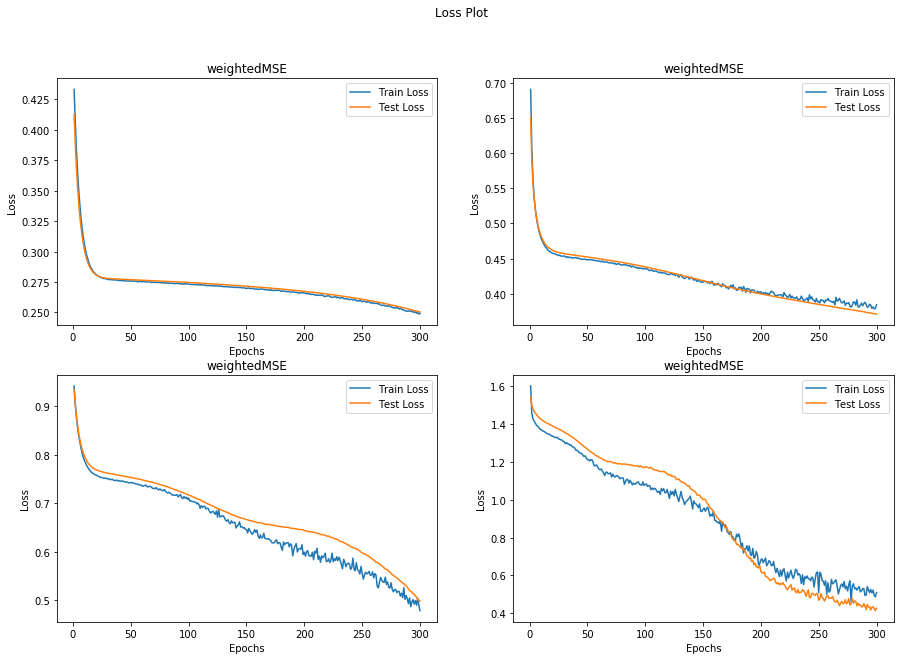

In [23]:
learner_2.plotLoss(figsize=(15,10))

In [24]:
print("wMSE_1:1:2"); print(learner_2.learners[0].train_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_2.learners[1].train_confusion_matrix_list[-1])
print("wMSE_1:1:10"); print(learner_2.learners[2].train_confusion_matrix_list[-1])
print("wMSE_1:1:20"); print(learner_2.learners[3].train_confusion_matrix_list[-1])

wMSE_1:1:2
[[50  1  0]
 [ 0 50  0]
 [22  9  0]]
wMSE_1:1:5
[[29 18  4]
 [ 5 43  2]
 [ 6  9 16]]
wMSE_1:1:10
[[49  0  2]
 [ 0 47  3]
 [ 6  6 19]]
wMSE_1:1:20
[[50  1  0]
 [ 0 49  1]
 [ 4  3 24]]


In [25]:
print("wMSE_1:1:2"); print(learner_2.learners[0].valid_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_2.learners[1].valid_confusion_matrix_list[-1])
print("wMSE_1:1:10"); print(learner_2.learners[2].valid_confusion_matrix_list[-1])
print("wMSE_1:1:20"); print(learner_2.learners[3].valid_confusion_matrix_list[-1])

wMSE_1:1:2
[[10  0  0]
 [ 0 12  0]
 [ 6  1  0]]
wMSE_1:1:5
[[2 7 1]
 [4 8 0]
 [1 2 4]]
wMSE_1:1:10
[[10  0  0]
 [ 0 12  0]
 [ 3  0  4]]
wMSE_1:1:20
[[10  0  0]
 [ 0 12  0]
 [ 1  0  6]]


In [ ]:
dataset_all = CANData.fromCSVFolder(globalVariables.path_to_csv, skip_labels=[1,2])
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_CANData_157_NewEdgeDetection_25Feb", 'wb') as f:
    pickle.dump(dataset_all, f)

In [ ]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovingObject2_157_NewEdgeDetection_25Feb", 'rb') as f:
    dataset_4=pickle.load(f)

In [ ]:
d=SingleCAN.fromCSV(dataset_4.can[1])

In [ ]:
name=dataset_4.can[1]

In [ ]:
print(len([1 for x,y in dataset_4 if y==0]))
print(len([1 for x,y in dataset_4 if y==1]))
print(len([1 for x,y in dataset_4 if y==2]))

In [ ]:
len(dataset_4)

In [ ]:
dataset_4.play(1)

In [ ]:
df=read_csv_auto(dataset_4.can[1])

In [ ]:
SingleCAN.getEdgePostABA(df, 0)

In [ ]:
plt.plot()

In [ ]:
dataset_4.play(6)

In [ ]:
plt.plot(laplace(read_csv_auto(dataset_4.can[4])["RDF_dx_Or"]))

Files with problem
17
18 - Night Time, Video over exposed


In [63]:
dataset_4.can[33]

'/home/sufiyan/data/Daimler/100_vids/csv/20170421_235710_S235_500K_V173015_HW_DML.csv'

In [36]:
dataset_4.play(20)

[602]
ABAReactionIndex:  518
Edge_0:  [602]
Edge_1:  [872]


In [66]:
dataset_4.play(34)

[547]
ABAReactionIndex:  473
Edge_0:  [547]
Edge_1:  [600]


[593]
ABAReactionIndex:  500
Edge_0:  [593]
Edge_1:  [726]
Reason for Braking:  Driving/Moving Object
Label:  0
edgePostABA:  592


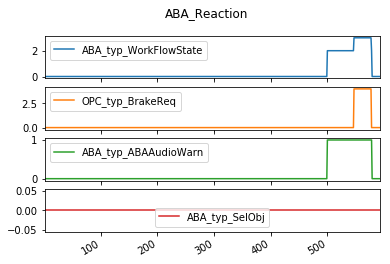

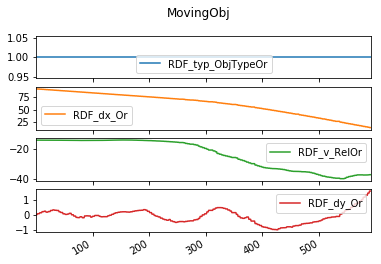

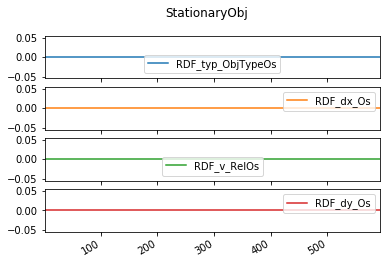

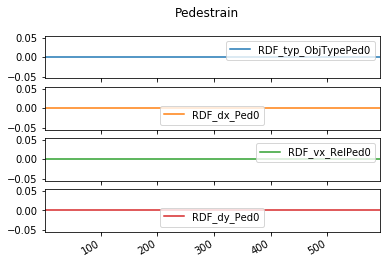

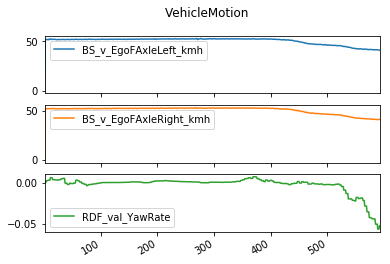

In [71]:
dataset_4.plot(37, all_columns=True, supressPostABA=True)

In [30]:
d=SingleCAN(read_csv_auto(name), name)

In [24]:
mv=MovingObject(read_csv_auto(name))

In [25]:
mv.getEdgePostABA(1)

469

Reason for Braking:  Driving/Moving Object


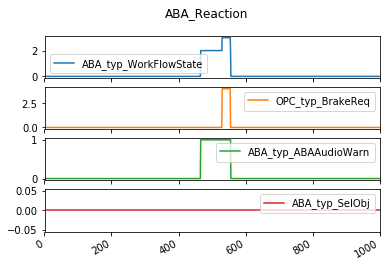

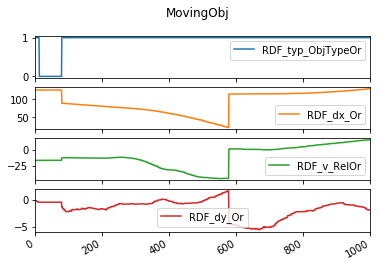

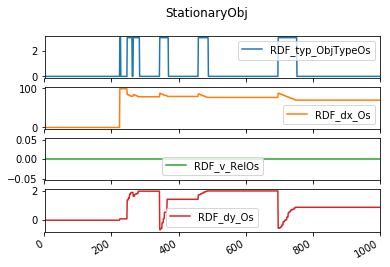

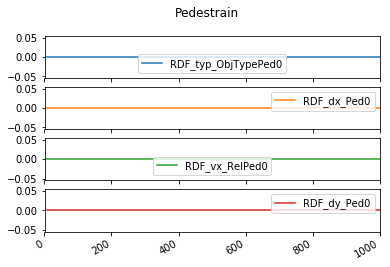

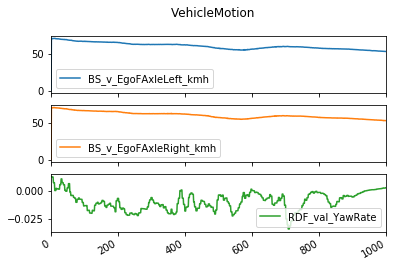

In [32]:
d.plot()